In [1]:
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

cpu


In [3]:
TRAIN_PATH = r"/Users/destinsaba/Documents/MEng/ENEL_645/dataset_group_5/train"
VAL_PATH = r"/Users/destinsaba/Documents/MEng/ENEL_645/dataset_group_5/val"
TEST_PATH = r"/Users/destinsaba/Documents/MEng/ENEL_645/dataset_group_5/test"

In [6]:
# Transforms 
torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225] )])


torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406] ,std=[0.229, 0.224, 0.225])])


# Load datasets
train_dataset = ImageFolder(root=TRAIN_PATH, transform= torchvision_transform)
val_dataset = ImageFolder(root=VAL_PATH, transform= torchvision_transform)
test_dataset = ImageFolder(root=TEST_PATH, transform= torchvision_transform_test)

# Define batch size and number of workers (adjust as needed)
batch_size = 4
num_workers = 4

# Create data loaders
trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
valloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [7]:
class_names = train_dataset.classes
print(class_names)
print("Train set:", len(trainloader)*batch_size)
print("Val set:", len(valloader)*batch_size)
print("Test set:", len(testloader)*batch_size)

['Black', 'Blue', 'Green', 'Other']
Train set: 32
Val set: 16
Test set: 16


In [8]:
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [9]:
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([4, 3, 224, 224])
torch.Size([4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


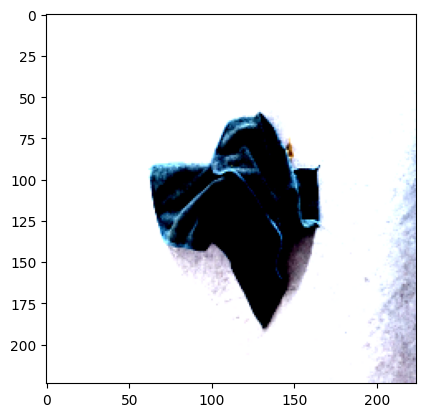

In [14]:
plt.figure()
plt.imshow(train_batch[0].numpy()[3].transpose(1,2,0))
plt.show()

In [15]:
class GarbageModel(nn.Module):
    def __init__(self,  num_classes, input_shape, transfer=False):
        super().__init__()

        self.transfer = transfer
        self.num_classes = num_classes
        self.input_shape = input_shape
        
        # transfer learning if weights=True
        self.feature_extractor = models.resnet18(weights=transfer)

        if self.transfer:
            # layers are frozen by using eval()
            self.feature_extractor.eval()
            # freeze params
            for param in self.feature_extractor.parameters():
                param.requires_grad = False

        n_features = self._get_conv_output(self.input_shape)
        self.classifier = nn.Linear(n_features, num_classes)

    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.autograd.Variable(torch.rand(batch_size, *shape))

        output_feat = self.feature_extractor(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    # will be used during inference
    def forward(self, x):
       x = self.feature_extractor(x)
       x = x.view(x.size(0), -1)
       x = self.classifier(x)
       
       return x

In [16]:
net = GarbageModel(4, (3,224,224), True)
net.to(device)

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/destinsaba/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 34.6MB/s]


GarbageModel(
  (feature_extractor): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=

In [17]:
criterion = nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.AdamW(net.parameters(), lr = 0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [18]:
nepochs = 20
PATH = './garbage_net.pth' # Path to save the best model

best_loss = 1e+20
for epoch in range(nepochs):  # loop over the dataset multiple times
    # Training Loop
    train_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f'{epoch + 1},  train loss: {train_loss / i:.3f},', end = ' ')
    scheduler.step()
    
    val_loss = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()
        print(f'val loss: {val_loss / i:.3f}')
        
        # Save best model
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
        
print('Finished Training')

1,  train loss: 2.487, val loss: 2.476
Saving model
2,  train loss: 1.053, val loss: 1.676
Saving model
3,  train loss: 0.641, val loss: 1.971
4,  train loss: 0.393, val loss: 2.205
5,  train loss: 0.363, val loss: 2.263
6,  train loss: 0.260, val loss: 2.074
7,  train loss: 0.220, val loss: 2.196
8,  train loss: 0.168, val loss: 1.784
9,  train loss: 0.128, val loss: 2.454
10,  train loss: 0.164, val loss: 2.135
11,  train loss: 0.114, val loss: 2.571
12,  train loss: 0.087, val loss: 2.492
13,  train loss: 0.082, val loss: 1.854
14,  train loss: 0.084, val loss: 2.265
15,  train loss: 0.099, val loss: 1.924
16,  train loss: 0.070, val loss: 2.290
17,  train loss: 0.089, val loss: 2.122
18,  train loss: 0.069, val loss: 2.124
19,  train loss: 0.083, val loss: 2.092
20,  train loss: 0.083, val loss: 2.321
Finished Training


In [19]:
# Load the best model to be used in the test set
net = GarbageModel(4, (3,224,224), False)
net.load_state_dict(torch.load(PATH))
#net.load_state_dict(torch.load(PATH))

/opt/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/var/folders/j2/977x17450p76552dqglp0zfw0000gn/T/ipykernel_13559/3516945123.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via 

<All keys matched successfully>

In [20]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {100 * correct / total} %')

Accuracy of the network on the test images: 43.75 %


In [21]:
print(total)

16
